# Program Synthesis for Dataset Augmentation with Symbolic Regression and Genetic Programming

In [58]:
# Ruchi Bhalani, rb44675
!pip install gplearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [59]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [60]:
# headers
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from collections import OrderedDict
from sklearn.model_selection import train_test_split

In [61]:
# function to calculate adjusted r2
def get_adj_r2(r2, n, p):
    return (1-(1-r2)*((n-1)/(n-p-1)))

# Assignment 2: Regression and KNN classifier

**Data Prep**


In [62]:
# NOTE: THESE VALUES ARE MEANT TO BE CUSTOMIZABLE BY THE USER
# read in data
# USER_INPUT_DATASET = "/content/drive/MyDrive/373P/FinalProjectCode/medical-charges.txt"
# USER_INPUT_DATASET = "/content/drive/MyDrive/373P/FinalProjectCode/breast_cancer.csv"
USER_INPUT_DATASET = "/content/drive/MyDrive/373P/FinalProjectCode/diabetes.csv"
# USER_INPUT_DATASET = "/content/drive/MyDrive/373P/FinalProjectCode/disease.csv"
EXPECTED_DISTINCT_PERCENTAGE = 0.85

# How many entries do we want to augment this dataset by?
# TODO: Let the user pass this in as a percentage as well
NEW_EXAMPLES = 10

# data = pd.read_csv(USER_INPUT_DATASET, header = 0)
df = pd.read_csv(USER_INPUT_DATASET, header="infer")
print(df.info())
print(df)


# DATA PREPROCESSING
df = df.dropna(axis=1, how='all')
# df = df.dropna()
df = df.fillna(0)


train_data, test_data = train_test_split(df, test_size=0.2, shuffle=False)
df = train_data

# Separate them into numerical, categorical, and proper noun columns (regex generation)
numerical_cols = list()
categorical_cols = list()
proper_noun_cols = list()
for (index, colname) in enumerate(df):
    if colname in df.select_dtypes(include='object').columns:
      unique_vals = df[colname].unique()
      if len(unique_vals) >= EXPECTED_DISTINCT_PERCENTAGE * df.shape[0]:
        proper_noun_cols.append(colname)
      else:
        categorical_cols.append(colname)
    else:
      numerical_cols.append(colname)


print(categorical_cols)
print(numerical_cols)
print("FINAL STEP: proper nouns --", proper_noun_cols)

df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None
     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6      148             72             35        0  33.6   
1              1       85             66             29        0  26.6   
2            

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


There are several categorical columns. We need to transform these to be able to do regression. 

In [63]:
# we'll deal with the proper noun columns at the end
regression_df = df.drop(columns=proper_noun_cols)
regression_df = pd.get_dummies(regression_df, columns=categorical_cols)
regression_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


An interesting thing to check with regression problems is whether any of the individual features correlate very strongly with the label.

In [64]:
print(regression_df.corr(), "\n\n")

# Indexing with numbers on a numpy matrix will probably be faster

print("=== SIGNIFICANTLY CORRELATED COLUMNS ===")
rows, cols = regression_df.shape
corr = regression_df.corr().values
fields = list(regression_df.columns)
correlated_columns = list()
nodes = []
correlations = OrderedDict()

# data structure that organizes correlations
correlations_per_column = list()
for i in range(cols):
    for j in range(i+1, cols):
      corr[i,j] = round(abs(corr[i,j]), 5)
      if corr[i,j] > 0.6:
          print(fields[i], ' ', fields[j], ' ', corr[i,j])
          correlated_columns.append([fields[i], fields[j], corr[i, j]])
          correlations[corr[i, j]] = [fields[i], fields[j]]
          if fields[i] not in nodes:
            nodes.append(fields[i])
          if fields[j] not in nodes:
            nodes.append(fields[j])

print(nodes)
print(correlations)

                          Pregnancies   Glucose  BloodPressure  SkinThickness  \
Pregnancies                  1.000000  0.136707       0.112177      -0.083398   
Glucose                      0.136707  1.000000       0.135931       0.060795   
BloodPressure                0.112177  0.135931       1.000000       0.210994   
SkinThickness               -0.083398  0.060795       0.210994       1.000000   
Insulin                     -0.056020  0.346124       0.101901       0.431684   
BMI                          0.036012  0.222744       0.275194       0.381554   
DiabetesPedigreeFunction    -0.047127  0.149888       0.022229       0.183296   
Age                          0.535479  0.273592       0.222201      -0.120908   
Outcome                      0.211148  0.458698       0.059317       0.076651   

                           Insulin       BMI  DiabetesPedigreeFunction  \
Pregnancies              -0.056020  0.036012                 -0.047127   
Glucose                   0.346124  0.222

We can visualize these attributes and their correlations as a weighted graph.

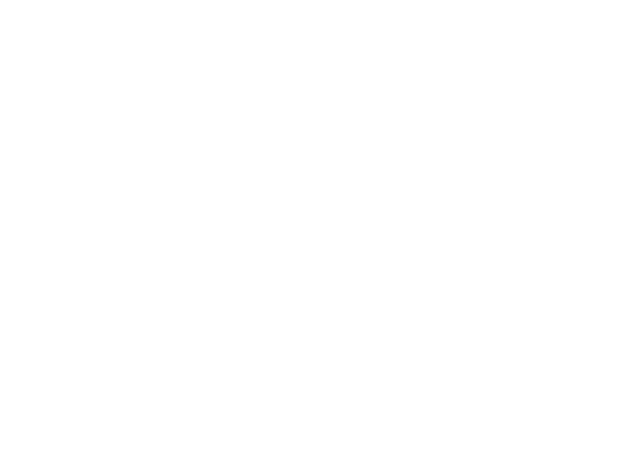

In [65]:
import matplotlib.pyplot as plt
import networkx as nx

G = nx.Graph()

for key,value in correlations.items():
  G.add_edge(value[0], value[1], weight=key)


elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > 0.5]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= 0.5]

pos = nx.spring_layout(G, seed=7)  # positions for all nodes - seed for reproducibility

# nodes
nx.draw_networkx_nodes(G, pos, node_size=700)

# edges
nx.draw_networkx_edges(G, pos, edgelist=elarge, width=6)
nx.draw_networkx_edges(
    G, pos, edgelist=esmall, width=6, alpha=0.5, edge_color="b", style="dashed"
)

# node labels
nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")
# edge weight labels
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels)

ax = plt.gca()
ax.margins(0.15)
plt.axis("off")
plt.tight_layout()
plt.show()

Now, let's organize them by pair and start generating values.

In [66]:
# weight all the correlations so that they're iterated through correctly
weighted_correlations = OrderedDict()
for key,value in correlations.items():
  mult_factor = 1
  if value[0] in numerical_cols:
    mult_factor *= 10
  if value[1] in numerical_cols:
    mult_factor *= 10
  weighted_correlations[mult_factor * key] = value

weighted_correlations = OrderedDict(sorted(weighted_correlations.items(), reverse=True))
print(weighted_correlations)


OrderedDict()


##Numerical Data Generation: Symbolic Regression
Now, let's augment the dataset with numerical data.

The code is implementing a technique for data augmentation using symbolic regression, kernel density estimation, and K-nearest neighbor regression. The goal is to generate new samples of data that are similar to the original dataset, but not identical, to increase the size and diversity of the dataset for training machine learning models. The code takes in a pandas DataFrame df and the number of new samples to generate n_samples as inputs.

The code first scales each column of the input dataset to the range [0, 1], fits a symbolic regressor to the scaled data, and generates new values using the regressor. It then applies kernel density estimation and K-nearest neighbor regression to the original data and generates new values using these methods. Finally, it performs a grid search to find the best kernel and bandwidth for the kernel density estimator, and generates new values using the best estimator.

The new values generated by each method are clipped to the range of the original column data, and the new values for all columns are combined to create a new DataFrame new_df. The new_df is then concatenated with the original DataFrame df to create an augmented dataset, which is returned as output.



In [67]:
import pandas as pd
import numpy as np
from sklearn.utils import check_random_state
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KernelDensity, KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from gplearn.genetic import SymbolicRegressor

def augment_dataset(df, n_samples):
    # Get column names and data types
    col_names = df.columns.tolist()
    dtypes = df.dtypes.tolist()

    # Create a list to store new data samples
    new_data = []

    # Loop through each column and generate new values
    for col_name, dtype in zip(col_names, dtypes):
        # Get the data from the column
        col_data = df[col_name].values

        # Scale the column data to the range [0, 1]
        scaler = MinMaxScaler()
        col_data_scaled = scaler.fit_transform(col_data.reshape(-1, 1))

        # Fit a symbolic regressor to the column data
        est_gp = SymbolicRegressor(population_size=5000, tournament_size=50,
                                    generations=50, stopping_criteria=0.01,
                                    p_crossover=0.7, p_subtree_mutation=0.1,
                                    p_hoist_mutation=0.05, p_point_mutation=0.1,
                                    max_samples=0.9, verbose=1,
                                    parsimony_coefficient=0.001, random_state=0, warm_start=True)
        est_gp.fit(col_data_scaled, col_data_scaled)

        # Generate new values using the symbolic regressor
        new_col_data = est_gp.predict(np.random.rand(n_samples, 1))

        # Reshape the new column data to be a 2D array
        new_col_data = new_col_data.reshape(-1, 1)

        # Scale the new column data using the scaler fitted to the original column data
        new_col_data_scaled = scaler.transform(new_col_data)

        # Inverse transform the scaled new column data to get the original scale
        new_col_data = scaler.inverse_transform(new_col_data_scaled)

        # Fit a kernel density estimator to the original column data
        kde = KernelDensity(kernel='gaussian', bandwidth=0.1)
        kde.fit(col_data.reshape(-1, 1))

        # Generate new values using the kernel density estimator
        kde_samples = kde.sample(n_samples)
        kde_samples = np.squeeze(kde_samples)

        # Fit a KNN regressor to the original column data
        knn = KNeighborsRegressor(n_neighbors=5)
        knn.fit(col_data_scaled, col_data_scaled)

        # Generate new values using the KNN regressor
        knn_samples = knn.predict(np.random.rand(n_samples, 1))
        knn_samples = np.squeeze(knn_samples)

        # Use a grid search to find the best kernel and bandwidth for the kernel density estimator
        params = {'kernel': ['gaussian', 'tophat', 'epanechnikov', 'exponential', 'linear'],
                  'bandwidth': np.linspace(0.1, 1.0, 10)}
        grid = GridSearchCV(KernelDensity(), params, cv=5)
        print("DATA SHAPE HERE: ", print(col_data.reshape(-1, 1).shape))
        grid.fit(col_data.reshape(-1, 1))
        # grid.fit(col_data)
        kde_best = grid.best_estimator_

        # Generate new values using the best kernel density estimator
        if kde_best.kernel in ["gaussian", "tophat"]:
            kde_best_samples = kde_best.sample(n_samples)
        else:
            # Evaluate log density for a grid of points
            x_grid = np.linspace(col_data.min(), col_data.max(), 1000).reshape(-1, 1)
            log_dens = kde_best.score_samples(x_grid)

            # Sample from the grid according to the log densities
            probs = np.exp(log_dens - log_dens.max())
            probs /= probs.sum()
            kde_best_samples = np.random.choice(x_grid.flatten(), size=n_samples, p=probs)
            
        kde_best_samples = np.squeeze(kde_best_samples)

        # Generate new values using the best kernel density estimator
        # kde_best_samples = kde_best.sample(n_samples)
        # kde_best_samples = np.squeeze(kde_best_samples)

        # Clip the new values to the range of the original column data
        kde_best_samples = np.clip(kde_best_samples, np.min(col_data), np.max(col_data))

        # Add new values to the list of new data
        new_data.append(kde_best_samples.flatten())

    # Transpose the list of new data to match the shape of the original dataset
    new_data = np.array(new_data).T

    # Convert the new data to a dataframe and append it to the original dataset
    new_df = pd.DataFrame(new_data, columns=col_names)
    augmented_df = pd.concat([df, new_df], ignore_index=True)

    # return augmented_df
    return new_df

print(np.seterr())
np.seterr(invalid='warn')
np.seterr(under='warn')
print(np.seterr())
new_df = augment_dataset(regression_df, df.shape[0])

{'divide': 'warn', 'over': 'warn', 'under': 'warn', 'invalid': 'warn'}
{'divide': 'warn', 'over': 'warn', 'under': 'warn', 'invalid': 'warn'}
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


   0    48.81          9826.21        7       0.00305441       0.00266057     14.53m
(614, 1)
DATA SHAPE HERE:  None


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [-180.35595604          -inf          -inf -108.61787859          -inf
 -227.97353849          -inf          -inf -189.1314716           -inf
 -269.90028508          -inf          -inf -231.02058119          -inf
 -293.6724088           -inf          -inf -254.86876972          -inf
 -301.4664062           -inf          -inf -269.44045919          -inf
 -303.23245023          -inf          -inf -279.02028535          -inf
 -303.93142753          -inf          -inf -285.76440289          -inf
 -304.64977229          -inf          -inf -290.80736463          -inf
 -305.49135824          -inf          -inf -294.77785479          -inf
 -306.42761029          -inf          -inf -298.04242473          -inf]
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:961: RuntimeWarning: invalid value encountered in subtract


    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    48.81          333.511        7       0.00821244       0.00810278     16.74m
(614, 1)
DATA SHAPE HERE:  None


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [-2647.61834852           -inf           -inf  -483.70565037
           -inf -1060.06317259           -inf           -inf
  -519.93196513           -inf  -799.06152604           -inf
           -inf  -546.08742387           -inf  -715.66553064
           -inf           -inf  -561.2945519            -inf
  -673.08457948           -inf           -inf  -570.30921521
           -inf  -647.65919076           -inf           -inf
  -575.96358349           -inf  -632.09245559           -inf
           -inf  -579.71063664           -inf  -622.17304102
           -inf           -inf  -582.31127863           -inf
  -615.53672254           -inf           -inf  -584.18581624
           -inf  -610.9018018            -inf           -inf
  -585.57955312           -inf]
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:961: R

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    48.81          277.954        7       0.00764004       0.00696911      7.63m
(614, 1)
DATA SHAPE HERE:  None


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [-2303.76312771           -inf           -inf  -280.01522692
           -inf  -843.86319959           -inf           -inf
  -332.76104986           -inf  -607.33197298           -inf
           -inf  -370.21825506           -inf  -540.66583616
           -inf           -inf  -397.09812427           -inf
  -518.5995448            -inf           -inf  -416.80222424
           -inf  -512.16244827           -inf           -inf
  -431.42230282           -inf  -510.67081891           -inf
           -inf  -442.41081909           -inf  -509.62838139
           -inf           -inf  -450.79521378           -inf
  -507.88583732           -inf           -inf  -457.29678737
           -inf  -505.69725762           -inf           -inf
  -462.42085119           -inf]
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:961: R

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    48.81          1042.86        7       0.00279196       0.00300038      7.84m
(614, 1)
DATA SHAPE HERE:  None


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [-13460.4108301             -inf            -inf   -300.67500889
            -inf  -3623.02859879            -inf            -inf
   -335.52288917            -inf  -1834.59298649            -inf
            -inf   -363.55527246            -inf  -1219.68031092
            -inf            -inf   -382.1706831             -inf
   -935.37456107            -inf            -inf   -394.97508097
            -inf   -781.1968293             -inf            -inf
   -404.33678683            -inf   -689.4259262             -inf
            -inf   -411.56805113            -inf   -631.03985122
            -inf            -inf   -417.40367907            -inf
   -591.9536139             -inf            -inf   -422.27458377
            -inf   -564.74988301            -inf            -inf
   -426.44701786            -inf]
  warnings.warn(
/usr/local/lib/python3.9/dist-

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    48.81          7063.92        7       0.00122896       0.00173112      6.58m
(614, 1)
DATA SHAPE HERE:  None


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [-207929.55314254             -inf             -inf   -1233.77851106
             -inf  -52239.6268235              -inf             -inf
    -802.48160281             -inf  -23442.02646936             -inf
             -inf    -678.49335707             -inf  -13379.15774491
             -inf             -inf    -624.9838077              -inf
   -8729.93713228             -inf             -inf    -597.48954562
             -inf   -6209.97388456             -inf             -inf
    -582.05508792             -inf   -4694.49959238             -inf
             -inf    -573.01108482             -inf   -3713.78066839
             -inf             -inf    -567.66000839             -inf
   -3043.56468254             -inf             -inf    -564.57384125
             -inf   -2565.86258079             -inf             -inf
    -562.93671553             -in

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    48.81          506.837        7       0.00642331       0.00626685      7.71m
(614, 1)
DATA SHAPE HERE:  None


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [-1236.09605549           -inf           -inf  -428.73817528
           -inf  -617.76687648           -inf           -inf
  -421.39371689           -inf  -504.02985506           -inf
           -inf  -419.04622095           -inf  -464.5628859
           -inf           -inf  -417.87273155           -inf
  -446.33115286           -inf           -inf  -417.20434255
           -inf  -436.45810347           -inf           -inf
  -416.80651112           -inf  -430.58199609           -inf
           -inf  -416.57035812           -inf  -426.85967412
           -inf           -inf  -416.43894068           -inf
  -424.38752618           -inf           -inf  -416.38012377
           -inf  -422.68102545           -inf           -inf
  -416.37457045           -inf]
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:961: Ru

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    48.81          34675.3        7       0.00229195       0.00257905      8.11m
(614, 1)
DATA SHAPE HERE:  None


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [ -11.08314823          -inf          -inf  -13.72547081          -inf
  -24.20178122  -14.45396633  -10.32473838  -28.05584229   -9.33173306
  -37.77610728  -24.7746607   -16.87051448  -42.63959123  -14.47302441
  -51.71575092  -34.20757878  -23.83687602  -56.69870993  -20.29764696
  -65.55576484  -42.71552485  -30.30590418  -69.92931143  -25.86982155
  -78.88210236  -52.37461387  -36.7723061   -82.22921934  -31.40496083
  -91.52066064  -62.98715259  -43.63763342  -93.61766679  -37.18208867
 -103.41957586  -73.92114352  -50.79623848 -104.16646936  -43.15887898
 -114.57872532  -84.44905323  -58.1604916  -113.9615327   -49.29320322
 -125.02867282  -94.35302923  -65.46743528 -123.08651426  -55.40931364]
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:961: RuntimeWarning: invalid value encountered in subtract


    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    48.81          26426.5        7       0.00278024       0.00238833      6.33m
(614, 1)
DATA SHAPE HERE:  None


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [-1847.10415409           -inf           -inf  -275.36485585
           -inf  -747.22163409           -inf           -inf
  -340.70138786           -inf  -576.54381382           -inf
           -inf  -376.8835413            -inf  -525.0179887
           -inf           -inf  -397.24863826           -inf
  -496.99930253           -inf           -inf  -409.33905072
           -inf  -479.02100912           -inf           -inf
  -417.01719922           -inf  -467.71230095           -inf
           -inf  -422.21939774           -inf  -460.51990967
           -inf           -inf  -425.95171967           -inf
  -455.80508135           -inf           -inf  -428.76495184
           -inf  -452.63130015           -inf           -inf
  -430.97698217           -inf]
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:961: Ru

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    48.81          59.9142        7                0                0      7.68m
(614, 1)
DATA SHAPE HERE:  None


In [68]:
# def reverse_one_hot_encode(df):
#     # Get a list of all columns with '_'
#     oh_cols = [col for col in df.columns if '_' in col]

#     # Get the original column names and values for each one-hot encoded column
#     col_vals = {}
#     for col in oh_cols:
#         col_name = col.split('_')[0]
#         col_val = col.split('_')[1]
#         if col_name not in col_vals:
#             col_vals[col_name] = {}
#         col_vals[col_name][col_val] = col

#     # Create a new dataframe to store the reverse one-hot encoded values
#     new_df = pd.DataFrame(columns=col_vals.keys())

#     # Iterate through each row of the original dataframe
#     for index, row in df.iterrows():
#         # Initialize a dictionary to store the values for this row
#         new_row = {}

#         # Iterate through each original column
#         for col_name in df.columns:
#             # If this is a one-hot encoded column, find the closest value to 1 and use that
#             if col_name in oh_cols:
#                 col_val = col_name.split('_')[1]
#                 col_key = col_vals[col_name.split('_')[0]][col_val]
                
#                 # Get the numeric values for the one-hot encoded column
#                 numeric_values = pd.to_numeric(row[col_key], errors='coerce')
#                 # Set values < 0.5 to 0 and values >= 0.5 to the numeric value
#                 numeric_values = np.where(numeric_values >= 0.5, numeric_values, 0)
#                 # Set the value closest to 1 to 1, and the rest to 0
#                 numeric_values = np.where(numeric_values == np.max(numeric_values), 1, 0)
#                 # Combine the column name and the value (if it's 1) and add it to the new_row dictionary
#                 new_row[col_name.split('_')[0]] = col_val if np.sum(numeric_values) > 0 else np.nan
#             # If this is not a one-hot encoded column, use the original value
#             else:
#                 new_row[col_name] = row[col_name]

#         # Append the values for this row to the new dataframe
#         new_df = new_df.append(new_row, ignore_index=True)

#     # Return the new dataframe
#     return new_df

In [69]:

# reprocess the data
import pandas as pd
import numpy as np



# just brings columns back to normal and replaces values with NaN
def reverse_one_hot_encode(df):
    oh_cols = [col for col in df.columns if "_" in col and col.split("_")[0] in categorical_cols]
    print(oh_cols)
    new_df = df.drop(columns=oh_cols).copy()
    for col in oh_cols:
        col_name, val = col.split("_")
        mask = df[col] == 1
        new_df[col_name] = np.nan
        new_df.loc[mask, col_name] = val
    return new_df




def print_significantly_correlated_colmns(df):
  print("=== SIGNIFICANTLY CORRELATED COLUMNS ===")
  rows, cols = df.shape
  corr = df.corr().values
  fields = list(df.columns)
  for i in range(cols):
      for j in range(i+1, cols-1):
        corr[i,j] = round(abs(corr[i,j]), 5)
        if corr[i,j] > 0.75:
            print(fields[i], ' ', fields[j], ' ', corr[i,j])

new_df = reverse_one_hot_encode(new_df)
corr1 = regression_df.corr()
corr2 = new_df.corr()
# print a matrix to see the difference in correlations
diff = np.abs(corr1) - np.abs(corr2)

print("Old: ", len(regression_df))
print("New: ", len(new_df))
print(diff)

# print(print_significantly_correlated_colmns(regression_df))
# print(print_significantly_correlated_colmns(new_df))
new_df.head()
print(new_df)

[]
Old:  614
New:  614
                          Pregnancies   Glucose  BloodPressure  SkinThickness  \
Pregnancies                  0.000000 -0.810298      -0.674421      -0.858128   
Glucose                     -0.810298  0.000000      -0.752904      -0.855096   
BloodPressure               -0.674421 -0.752904       0.000000      -0.593067   
SkinThickness               -0.858128 -0.855096      -0.593067       0.000000   
Insulin                     -0.895706 -0.512708      -0.577891      -0.418462   
BMI                         -0.899858 -0.760644      -0.624358      -0.547200   
DiabetesPedigreeFunction    -0.926052 -0.759727      -0.740592      -0.716671   
Age                         -0.457131 -0.660524      -0.530179      -0.791314   
Outcome                     -0.657076 -0.351559      -0.560706      -0.698379   

                           Insulin       BMI  DiabetesPedigreeFunction  \
Pregnancies              -0.895706 -0.899858                 -0.926052   
Glucose           

## Categorical Variable Generation: Hill Climbing Algorithm
In this implementation, we use a hill-climbing algorithm to search for the best categorical variable distribution that matches the original distribution and is correlated with the numerical variables in the generated data. The algorithm starts with the original distribution and iteratively perturbs it by swapping two values, then computes the correlation with the numerical variables and updates the distribution if the correlation improves. The algorithm repeats this process for a fixed number of iterations (in this case, 10), then moves on to the next categorical variable.

This is an example of an explicit search or optimization technique for program synthesis, as we are searching for the best program (i.e., categorical variable distribution) that satisfies certain constraints (i.e., matching the original distribution and being correlated with the numerical variables).

In [70]:
import random
import copy

def generate_categorical_variables(original_data, generated_data):
    # Extract the original categorical variables
    original_categorical_data = original_data.select_dtypes(include=['object'])
    
    # Extract the generated numerical variables
    generated_numerical_data = generated_data.select_dtypes(include=['int64', 'float64'])
    
    # Generate new categorical variables for the generated data using hill-climbing algorithm
    new_categorical_data = copy.deepcopy(original_categorical_data)
    for col in new_categorical_data.columns:
        current_distribution = original_categorical_data[col].value_counts(normalize=True)
        for _ in range(10):
            # Perturb the distribution by swapping two values
            i, j = random.sample(range(len(current_distribution)), 2)
            new_distribution = current_distribution.copy()
            new_distribution[i], new_distribution[j] = new_distribution[j], new_distribution[i]
            new_distribution /= new_distribution.sum()

            # Compute the correlation with the numerical variables
            new_correlation = abs(generated_numerical_data.corrwith(new_categorical_data[col].replace(current_distribution), axis=0))
            current_correlation=abs(generated_numerical_data.corrwith(new_categorical_data[col].replace(current_distribution), axis=0))*-1
            # Update the categorical variable if the correlation improves
            if new_correlation.sum() > current_correlation.sum():
                current_correlation = new_correlation
                new_categorical_data[col] = np.random.choice(new_distribution.index, size=len(new_categorical_data), p=new_distribution.values)
    
    # Replace the NaNs in the generated data with the new categorical data
    generated_data.update(new_categorical_data)
    
    return generated_data


final_df = generate_categorical_variables(df, new_df)
# final_df.head()

final_df = pd.concat([df, final_df], axis=0)
final_df_normalized = pd.get_dummies(final_df, columns=categorical_cols)
complete_encoded = pd.concat([final_df_normalized, regression_df], axis=0)
print(regression_df.corr())
print(complete_encoded.corr())

# make sure that all columns are rounded appropriately
for col in final_df.columns:
  if col in numerical_cols:
    # print(col)
    # all(print(x) for x in col)
    if all((x*1.0).is_integer() for x in df[col]):
      final_df[col] = np.round(final_df[col], 0)
      # print(final_df[col])
      print(final_df[col].value_counts())

# print(final_df)
final_df.head()


                          Pregnancies   Glucose  BloodPressure  SkinThickness  \
Pregnancies                  1.000000  0.136707       0.112177      -0.083398   
Glucose                      0.136707  1.000000       0.135931       0.060795   
BloodPressure                0.112177  0.135931       1.000000       0.210994   
SkinThickness               -0.083398  0.060795       0.210994       1.000000   
Insulin                     -0.056020  0.346124       0.101901       0.431684   
BMI                          0.036012  0.222744       0.275194       0.381554   
DiabetesPedigreeFunction    -0.047127  0.149888       0.022229       0.183296   
Age                          0.535479  0.273592       0.222201      -0.120908   
Outcome                      0.211148  0.458698       0.059317       0.076651   

                           Insulin       BMI  DiabetesPedigreeFunction  \
Pregnancies              -0.056020  0.036012                 -0.047127   
Glucose                   0.346124  0.222

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0,1.0
1,1.0,85.0,66.0,29.0,0.0,26.6,0.351,31.0,0.0
2,8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0,1.0
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0.0
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,1.0


Let's view both distributions to evaluate the quality of these generated values.

The distributions are not similar.


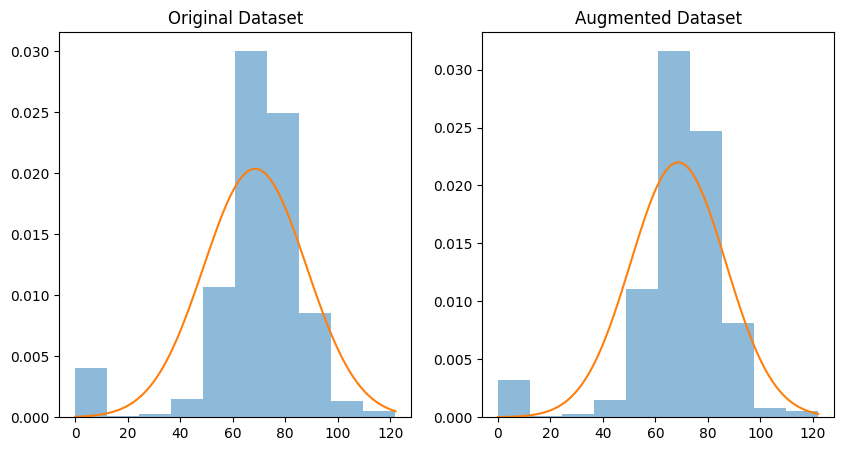

In [71]:
from scipy.stats import norm

def compare_distributions(list1, list2):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

    # Plot histograms
    ax1.hist(list1, density=True, alpha=0.5)
    ax2.hist(list2, density=True, alpha=0.5)

    # Fit normal distributions
    mu1, std1 = norm.fit(list1)
    mu2, std2 = norm.fit(list2)

    # Plot normal distribution curves
    x1 = np.linspace(min(list1), max(list1), 100)
    ax1.plot(x1, norm.pdf(x1, mu1, std1))
    ax1.set_title('Original Dataset')
    ax2.set_title('Augmented Dataset')
    x2 = np.linspace(min(list2), max(list2), 100)
    ax2.plot(x2, norm.pdf(x2, mu2, std2))

    # Check if distributions are similar
    if np.allclose(mu1, mu2) and np.allclose(std1, std2):
        print('The distributions are similar.')
    else:
        print('The distributions are not similar.')

    plt.show()

compare_distributions(list(df[numerical_cols[2]]), list(new_df[numerical_cols[2]]))

It seems like the criteria for determining if the distributions are similar is too strict, especially given that we are working off a small dataset.

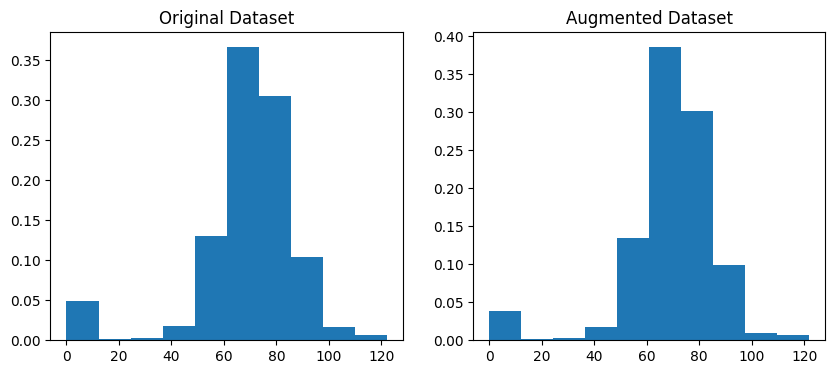

KL DIVERGENCE:  0.0033091043528511487
The distributions are similar


True

In [72]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

def compare_distributions_tolerance(list1, list2, tolerance=0.07):
    """Compares the distributions of two lists and plots them side by side.

    Args:
        list1 (list): The first list to compare.
        list2 (list): The second list to compare.
        tolerance (float): The tolerance for accepting similarity between the distributions.

    Returns:
        bool: True if the distributions are similar, False otherwise.
    """
    # Calculate the histograms for the two lists
    hist1, bins1 = np.histogram(list1, density=True)
    hist2, bins2 = np.histogram(list2, density=True)

    # Normalize the histograms to have unit area
    hist1 = hist1 / np.sum(hist1)
    hist2 = hist2 / np.sum(hist2)

    # Calculate the KL divergence between the two histograms
    kl_div = stats.entropy(hist2, hist1)

    # Plot the histograms side by side
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].bar(bins1[:-1], hist1, width=np.diff(bins1), align='edge')
    ax[1].bar(bins2[:-1], hist2, width=np.diff(bins2), align='edge')
    ax[0].set_title('Original Dataset')
    ax[1].set_title('Augmented Dataset')

    plt.show()

    # Check if the KL divergence is within the tolerance
    print("KL DIVERGENCE: ", kl_div)
    similar = True if kl_div <= tolerance else False

    if similar:
      print("The distributions are similar")
    else:
      print("The distrubutions are NOT similar")
    return similar


compare_distributions_tolerance(list(df[numerical_cols[2]]), list(new_df[numerical_cols[2]]))
# new_df.to_csv('augmented_dataset.csv', index=False)

# PUT IT ALL TOGETHER

In [73]:
# def prepare_for_regression(df, categorical_cols, proper_noun_cols=None):
#   regression_df = df.drop(columns=proper_noun_cols)
#   regression_df = pd.get_dummies(regression_df, columns=categorical_cols)
#   return regression_df

# def separate_columns(df):
#   numerical_cols = list()
#   categorical_cols = list()
#   proper_noun_cols = list()
#   for (index, colname) in enumerate(df):
#       if colname in df.select_dtypes(include='object').columns:
#         unique_vals = df[colname].unique()
#         if len(unique_vals) >= 0.85 * df.shape[0]:
#           proper_noun_cols.append(colname)
#         else:
#           categorical_cols.append(colname)
#       else:
#         numerical_cols.append(colname)
#   return numerical_cols, categorical_cols, proper_noun_cols

# def run_data_augmenter(dataset, num_samples=None, percentage_augmentation=None):
#     df = pd.read_csv(dataset, header="infer")
#     print(df.info())
#     print(df)


#     # DATA PREPROCESSING
#     df = df.dropna(axis=1, how='all')
#     # df = df.dropna()
#     df = df.fillna(0)
#     new_data = 0
#     if num_samples != None:
#       new_data = num_samples
#     else:
#       new_data = int(df.shape[0] * percentage_augmentation)
    
#     numerical_cols, categorical_cols, _ = separate_columns(df)
#     regression_df = prepare_for_regression(df, categorical_cols)
    
#     np.seterr(invalid='warn') 
#     np.seterr(under='warn')
    
#     new_df = augment_dataset(regression_df, new_data)
#     new_df = reverse_one_hot_encode(new_df, categorical_cols)

    
#     num_cat_generated = generate_categorical_variables(df, new_df)
#     # final_df.head()

#     final_df = pd.concat([df, num_cat_generated], axis=0)

#     # make sure that all columns are rounded appropriately
#     for col in final_df.columns:
#       if col in numerical_cols:
#         # print(col)
#         # all(print(x) for x in col)
#         if all((x*1.0).is_integer() for x in df[col]):
#           final_df[col] = np.round(final_df[col], 0)
#           # print(final_df[col])
#           print(final_df[col].value_counts())
    
#     return final_df

##Downstream ML task

To demonstrate the usefulness of this dataset augmentation, we're going to be predicting the diabetes diagnoses of patients.

In [74]:
augmented_train_data = final_df

# original dataset train data is stored in train data
# original dataset test data is stored in test data

# augmented dataset train data is stored in final_df
# augmented dataset test data is stored in test data

if 'id' in train_data.columns:
  train_data = train_data.drop(columns=['id'])

if 'id' in test_data.columns:
  test_data = test_data.drop(columns=['id'])

if 'id' in final_df.columns:
  augmented_train_data = final_df.drop(columns=['id'])




experiments = []
accuracies = []
precisions = []
recalls = []
train_percentages=[]
test_percentages=[]



import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense
import keras.metrics
from sklearn.metrics import classification_report



# Load the dataset
# data = pd.read_csv('path/to/dataset.csv')

# Split the dataset into train and test sets
## UNCOMMENT THIS
# test_size = 0.2
# train_data, test_data = train_test_split(eval_original_df, test_size=test_size, shuffle=False)

# Separate the target variable from the features in the train and test sets
# train_X, train_y = train_data.iloc[:, 1:], train_data.iloc[:, 0]
# test_X, test_y = test_data.iloc[:, 1:], test_data.iloc[:, 0]


train_X, train_y = train_data.iloc[:, :-1], train_data.iloc[:, -1]
test_X, test_y = test_data.iloc[:, :-1], test_data.iloc[:, -1]

print(train_data)
# print(test_y)
print(train_y)
# Encode the target variable
encoder = LabelEncoder()
train_y = encoder.fit_transform(train_y)
test_y = encoder.transform(test_y)

# Create the neural network model
model = Sequential()
model.add(Dense(12, input_dim=train_X.shape[1], activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])

# Fit the model to the train set
model.fit(train_X, train_y, epochs=150, batch_size=10)


# Evaluate the model on the test set
_, accuracy, precision, recall = model.evaluate(test_X, test_y)
print('Accuracy: %.2f%%' % (accuracy*100))
print('Precision: %.2f%%' % (precision*100))
print('Recall: %.2f%%' % (recall*100))
experiments.append("Original dataset")
accuracies.append(accuracy)
precisions.append(precision)
recalls.append(recall)



     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6      148             72             35        0  33.6   
1              1       85             66             29        0  26.6   
2              8      183             64              0        0  23.3   
3              1       89             66             23       94  28.1   
4              0      137             40             35      168  43.1   
..           ...      ...            ...            ...      ...   ...   
609            1      111             62             13      182  24.0   
610            3      106             54             21      158  30.9   
611            3      174             58             22      194  32.9   
612            7      168             88             42      321  38.2   
613            6      105             80             28        0  32.5   

     DiabetesPedigreeFunction  Age  Outcome  
0                       0.627   50        1  
1                  

In [75]:
# test_size = 5/9.0
# train_data, test_data = train_test_split(eval_augmented_df, test_size=test_size, shuffle=False)

# Separate the target variable from the features in the train and test sets
# train_X, train_y = augmented_train_data.iloc[:, 1:], augmented_train_data.iloc[:, 0]
# test_X, test_y = test_data.iloc[:, 1:], test_data.iloc[:, 0]


# last column
train_X, train_y = augmented_train_data.iloc[:, :-1], augmented_train_data.iloc[:, -1]
test_X, test_y = test_data.iloc[:, :-1], test_data.iloc[:, -1]

print(train_y)
# print(test_data)
# Encode the target variable
encoder = LabelEncoder()
train_y = encoder.fit_transform(train_y)
test_y = encoder.transform(test_y)

# Create the neural network model
model = Sequential()
model.add(Dense(12, input_dim=train_X.shape[1], activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])

# Fit the model to the train set
model.fit(train_X, train_y, epochs=150, batch_size=10)


# Evaluate the model on the test set
_, accuracy, precision, recall = model.evaluate(test_X, test_y)
print('Accuracy: %.2f%%' % (accuracy*100))
print('Precision: %.2f%%' % (precision*100))
print('Recall: %.2f%%' % (recall*100))


experiments.append("Augmented dataset")
accuracies.append(accuracy)
precisions.append(precision)
recalls.append(recall)


0      1.0
1      0.0
2      1.0
3      0.0
4      1.0
      ... 
609    0.0
610    1.0
611    0.0
612    0.0
613    1.0
Name: Outcome, Length: 1228, dtype: float64
Epoch 1/150
123/123 [==============================] - 1s 2ms/step - loss: 1.2539 - accuracy: 0.6710 - precision_7: 0.5026 - recall_7: 0.7224
Epoch 2/150
123/123 [==============================] - 0s 2ms/step - loss: 0.5947 - accuracy: 0.7410 - precision_7: 0.6052 - recall_7: 0.6290
Epoch 3/150
123/123 [==============================] - 0s 2ms/step - loss: 0.5436 - accuracy: 0.7557 - precision_7: 0.6314 - recall_7: 0.6314
Epoch 4/150
123/123 [==============================] - 0s 2ms/step - loss: 0.5235 - accuracy: 0.7573 - precision_7: 0.6423 - recall_7: 0.6044
Epoch 5/150
123/123 [==============================] - 0s 2ms/step - loss: 0.5080 - accuracy: 0.7671 - precision_7: 0.6571 - recall_7: 0.6216
Epoch 6/150
123/123 [==============================] - 0s 2ms/step - loss: 0.4957 - accuracy: 0.7663 - precision_7: 0.6554 - 

##Experimental Results Summary

In [76]:
data = {
    "Accuracy": accuracies,
    "Precision": precisions,
    "Recall": recalls
}

# Create a Pandas DataFrame from the dictionary
results = pd.DataFrame(data, index=experiments)

# Print the DataFrame
print(results)

                   Accuracy  Precision    Recall
Original dataset   0.714286   0.617021  0.527273
Augmented dataset  0.753247   0.666667  0.618182
